In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import joblib

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


### 1. INTRODUCTION

In [83]:
print("=" * 80)
print("PHASE 1: LOADING DATASETS")
print("=" * 80)

# 1. Load Evolution of Country Share data
print("\n1. Loading Country Share Data...")
country_share = pd.read_csv('Evolution of country share.csv')
print(f"Shape: {country_share.shape}")
print(f"Columns: {country_share.columns.tolist()}")
print(f"Date range: {country_share['date'].min()} to {country_share['date'].max()}")
print("\nFirst few rows:")
print(country_share.head())

# 2. Load Renewable Bitcoin Mining data
print("\n2. Loading Renewable Mining Data...")
# Try to load the correct sheet - adjust sheet name if needed
renewable_mining = pd.read_excel('Renewable Bitcoin Mining_Chai.xlsx', sheet_name='Final')
print(f"Shape: {renewable_mining.shape}")
print(f"Columns: {renewable_mining.columns.tolist()}")
print("\nFirst few rows:")
print(renewable_mining.head())

# 3. Load World Governance Indicators
print("\n3. Loading WGI Data...")
wgi_data = pd.read_excel('wgidataset.xlsx')
print(f"Shape: {wgi_data.shape}")
print(f"Unique indicators: {wgi_data['indicator'].unique()}")
print(f"Year range: {wgi_data['year'].min()} to {wgi_data['year'].max()}")

# 4. Load IEA Monthly Electricity Statistics
print("\n4. Loading IEA Data...")
# Skip the header rows as identified earlier
iea_data = pd.read_csv('MES_0325.csv', skiprows=8)
print(f"Shape: {iea_data.shape}")
print(f"Columns: {iea_data.columns.tolist()}")

PHASE 1: LOADING DATASETS

1. Loading Country Share Data...
Shape: (290, 4)
Columns: ['date', 'country', 'monthly_hashrate_%', 'monthly_absolute_hashrate_EH/S']
Date range: 2019-09-01 to 2022-01-01

First few rows:
         date             country monthly_hashrate_%  \
0  2019-09-01      Mainland China             75.53%   
1  2019-09-01               Other               6.1%   
2  2019-09-01  Russian Federation              5.93%   
3  2019-09-01       United States              4.06%   
4  2019-09-01            Malaysia              3.25%   

   monthly_absolute_hashrate_EH/S  
0                           66.76  
1                            5.39  
2                            5.24  
3                            3.59  
4                            2.88  

2. Loading Renewable Mining Data...
Shape: (95, 29)
Columns: ['Company', 'Partner', 'Country', 'State', 'Location', 'Property Information', 'Hashing Capacity (EH/s) - Most recent', 'POWER CONSUMPTION (MW)', 'MORE POWER CONSUMPTION 


### 2. DATA COLLECTION AND PREPARATION

In [96]:
print("\n" + "=" * 80)
print("PHASE 2: DATA CLEANING")
print("=" * 80)

# Clean Country Share Data
print("\n1. Cleaning Country Share Data...")
country_share['date'] = pd.to_datetime(country_share['date'])

# Convert percentage strings to floats safely
if country_share['monthly_hashrate_%'].dtype == object:
    country_share['hashrate_percent'] = (
        country_share['monthly_hashrate_%']
        .str.rstrip('%')
        .astype(float)
    )
else:
    country_share['hashrate_percent'] = country_share['monthly_hashrate_%']

country_share['year'] = country_share['date'].dt.year
country_share['month'] = country_share['date'].dt.month

# Check for missing values
print("Missing values in country_share:")
print(country_share.isnull().sum())

# Clean Renewable Mining Data
print("\n2. Cleaning Renewable Mining Data...")

# First clean all percentage columns
percent_cols = ['WIND%', 'SOLAR%', 'HYDRO%', 'NUCLEAR%', 'NATURAL GAS%', 'COAL%']

def clean_percentage_col(col):
    if col.dtype == object:
        # Handle mixed types
        col = col.astype(str)
        col = col.str.replace('%', '')
        # Replace non-numeric values with NaN
        col = pd.to_numeric(col, errors='coerce')
    return col.fillna(0)

for col in percent_cols:
    if col in renewable_mining.columns:
        renewable_mining[col] = clean_percentage_col(renewable_mining[col])

# Now calculate percentages
renewable_mining['total_renewable_percent'] = (
    renewable_mining['WIND%'] + 
    renewable_mining['SOLAR%'] + 
    renewable_mining['HYDRO%'] + 
    renewable_mining['NUCLEAR%']
)

renewable_mining['fossil_fuel_percent'] = (
    renewable_mining['NATURAL GAS%'] + 
    renewable_mining['COAL%']
)

# Clean status column
renewable_mining['STATUS'] = renewable_mining['STATUS'].fillna('Unknown')

# Check for missing values
print("Missing values in key columns:")
key_cols = ['Company', 'Country', 'POWER CONSUMPTION (MW)', 'total_renewable_percent']
for col in key_cols:
    if col in renewable_mining.columns:
        missing_count = renewable_mining[col].isnull().sum()
        print(f"{col}: {missing_count}")

# Clean WGI Data
print("\n3. Cleaning WGI Data...")
# Filter for relevant years (2019 onwards to match other data)
wgi_recent = wgi_data[wgi_data['year'] >= 2019].copy()

# Convert estimate to numeric - THIS IS THE CRITICAL FIX
wgi_recent['estimate'] = pd.to_numeric(wgi_recent['estimate'], errors='coerce')

# Pivot WGI data for easier use
wgi_pivot = wgi_recent.pivot_table(
    index=['countryname', 'code', 'year'], 
    columns='indicator', 
    values='estimate',
    aggfunc='mean'  # Explicit aggregation function
).reset_index()

# Indicator meanings:
# cc: Control of Corruption
# ge: Government Effectiveness  
# pv: Political Stability and Absence of Violence
# rl: Rule of Law
# rq: Regulatory Quality
# va: Voice and Accountability

print(f"WGI pivoted shape: {wgi_pivot.shape}")
print(f"Countries in WGI: {wgi_pivot['countryname'].nunique()}")

# Clean IEA Data
print("\n4. Cleaning IEA Data...")
# Filter for electricity data and recent years
iea_electricity = iea_data[
    (iea_data['Product'] == 'Electricity') & 
    (iea_data['Balance'] == 'Net Electricity Production')
].copy()

# Convert time to datetime
iea_electricity['date'] = pd.to_datetime(iea_electricity['Time'], format='%B %Y', errors='coerce')
iea_electricity = iea_electricity[iea_electricity['date'] >= '2019-01-01']

print(f"IEA filtered shape: {iea_electricity.shape}")
print(f"Countries in IEA: {iea_electricity['Country'].nunique()}")


PHASE 2: DATA CLEANING

1. Cleaning Country Share Data...
Missing values in country_share:
date                              0
country                           0
monthly_hashrate_%                0
monthly_absolute_hashrate_EH/S    0
hashrate_percent                  0
year                              0
month                             0
dtype: int64

2. Cleaning Renewable Mining Data...
Missing values in key columns:
Company: 8
Country: 8
POWER CONSUMPTION (MW): 0
total_renewable_percent: 0

3. Cleaning WGI Data...
WGI pivoted shape: (1065, 9)
Countries in WGI: 213

4. Cleaning IEA Data...
IEA filtered shape: (3951, 7)
Countries in IEA: 53


### 3. EXPLORATORY DATA ANALYSIS

In [97]:
print("\n" + "=" * 80)
print("PHASE 3: EXPLORATORY DATA ANALYSIS")
print("=" * 80)


PHASE 3: EXPLORATORY DATA ANALYSIS



3.1 Mining Distribution Analysis

Top 10 Mining Countries as of 2022-01:
                country  hashrate_percent  monthly_absolute_hashrate_EH/S
280       United States             37.84                           70.97
281      Mainland China             21.11                           39.60
282          Kazakhstan             13.22                           24.80
283               Other              9.02                           16.92
284              Canada              6.48                           12.15
285  Russian Federation              4.66                            8.75
286           Germany *              3.06                            5.74
287            Malaysia              2.51                            4.70
288           Ireland *              1.97                            3.69
289  Iran, Islamic Rep.              0.12                            0.23


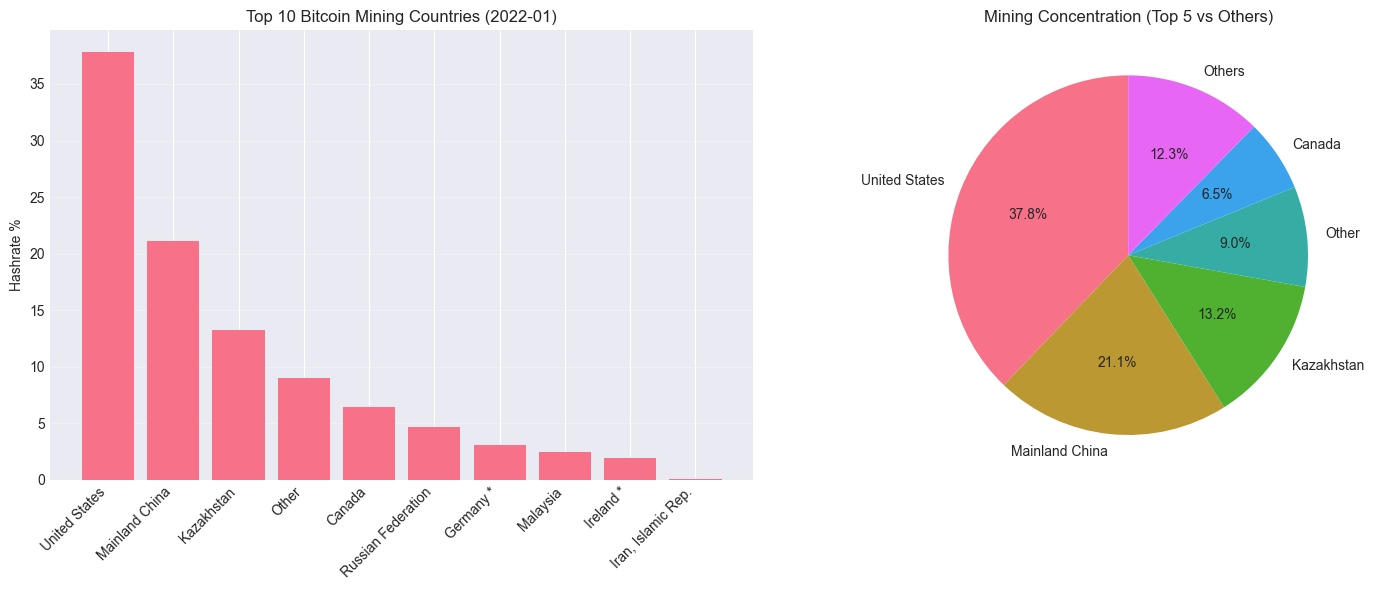

In [98]:
print("\n3.1 Mining Distribution Analysis")

# Get latest mining distribution
latest_date = country_share['date'].max()
latest_distribution = country_share[country_share['date'] == latest_date].copy()
latest_distribution = latest_distribution.sort_values('hashrate_percent', ascending=False)

print(f"\nTop 10 Mining Countries as of {latest_date.strftime('%Y-%m')}:")
print(latest_distribution[['country', 'hashrate_percent', 'monthly_absolute_hashrate_EH/S']].head(10))

# Visualization 1: Current Mining Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart of top 10 countries
top10 = latest_distribution.head(10)
ax1.bar(range(len(top10)), top10['hashrate_percent'])
ax1.set_xticks(range(len(top10)))
ax1.set_xticklabels(top10['country'], rotation=45, ha='right')
ax1.set_ylabel('Hashrate %')
ax1.set_title(f'Top 10 Bitcoin Mining Countries ({latest_date.strftime("%Y-%m")})')
ax1.grid(axis='y', alpha=0.3)

# Pie chart showing concentration
top5 = latest_distribution.head(5)
other_percent = 100 - top5['hashrate_percent'].sum()
pie_data = list(top5['hashrate_percent']) + [other_percent]
pie_labels = list(top5['country']) + ['Others']

ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Mining Concentration (Top 5 vs Others)')

plt.tight_layout()
plt.show()


3.2 China Ban Impact Analysis


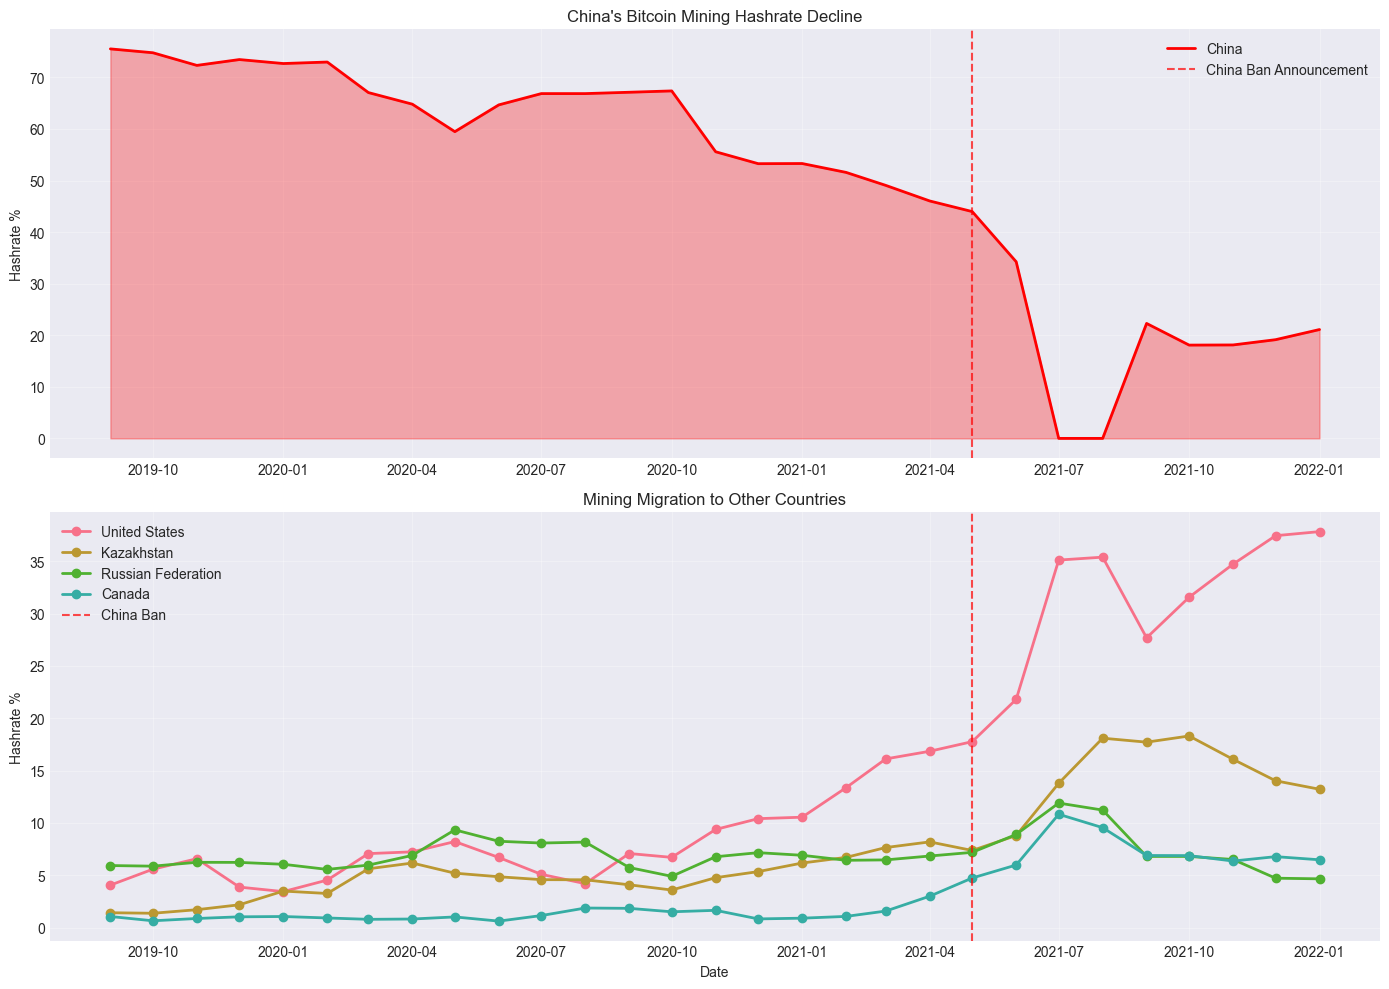


Hashrate Changes (Apr 2021 vs Jan 2022):
Mainland China         46.0% ->   21.1% (Change:  -24.9%)
United States          16.9% ->   37.8% (Change:  +21.0%)
Kazakhstan              8.2% ->   13.2% (Change:   +5.0%)
Russian Federation      6.8% ->    4.7% (Change:   -2.2%)
Canada                  3.0% ->    6.5% (Change:   +3.5%)


In [99]:
print("\n3.2 China Ban Impact Analysis")

# Analyze China's hashrate over time
china_data = country_share[country_share['country'] == 'Mainland China'].copy()
china_data = china_data.sort_values('date')

# Key countries to track
key_countries = ['Mainland China', 'United States', 'Kazakhstan', 'Russian Federation', 'Canada']
countries_timeline = country_share[country_share['country'].isin(key_countries)].copy()

# Visualization 2: Timeline Analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# China's decline
ax1.plot(china_data['date'], china_data['hashrate_percent'], 'r-', linewidth=2, label='China')
ax1.axvline(x=pd.Timestamp('2021-05-01'), color='red', linestyle='--', alpha=0.7, label='China Ban Announcement')
ax1.fill_between(china_data['date'], china_data['hashrate_percent'], alpha=0.3, color='red')
ax1.set_ylabel('Hashrate %')
ax1.set_title("China's Bitcoin Mining Hashrate Decline")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Other countries' growth
for country in key_countries:
    if country != 'Mainland China':
        country_data = countries_timeline[countries_timeline['country'] == country]
        ax2.plot(country_data['date'], country_data['hashrate_percent'], marker='o', label=country, linewidth=2)

ax2.axvline(x=pd.Timestamp('2021-05-01'), color='red', linestyle='--', alpha=0.7, label='China Ban')
ax2.set_ylabel('Hashrate %')
ax2.set_xlabel('Date')
ax2.set_title('Mining Migration to Other Countries')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate migration statistics
pre_ban = country_share[country_share['date'] == '2021-04-01']
post_ban = country_share[country_share['date'] == '2022-01-01']

print("\nHashrate Changes (Apr 2021 vs Jan 2022):")
for country in key_countries:
    pre_val = pre_ban[pre_ban['country'] == country]['hashrate_percent'].values
    post_val = post_ban[post_ban['country'] == country]['hashrate_percent'].values
    if len(pre_val) > 0 and len(post_val) > 0:
        change = post_val[0] - pre_val[0]
        print(f"{country:20} {pre_val[0]:6.1f}% -> {post_val[0]:6.1f}% (Change: {change:+6.1f}%)")


3.3 Renewable Energy Analysis

Top 10 Countries by Mining Capacity:
         Country  Total_MW  Avg_Renewable_%  Avg_Fossil_%  Num_Facilities
9  United States    1270.4         0.903294      0.035059              17
6       Paraguay     696.5         0.999792      0.000063              48
1         Canada     297.0         0.992500      0.002250              12
2    El Salvador     241.0         0.999950      0.000000               1
5         Norway     214.0         1.000000      0.000000               2
0         Bhutan     100.0         1.000000      0.000000               1
8         Sweden      78.0         1.000000      0.000000               3
4        Iceland      10.0         1.000000      0.000000               1
3       Ethiopia       1.5         0.000000      0.000000               1
7          Spain       0.5         1.000000      0.000000               1


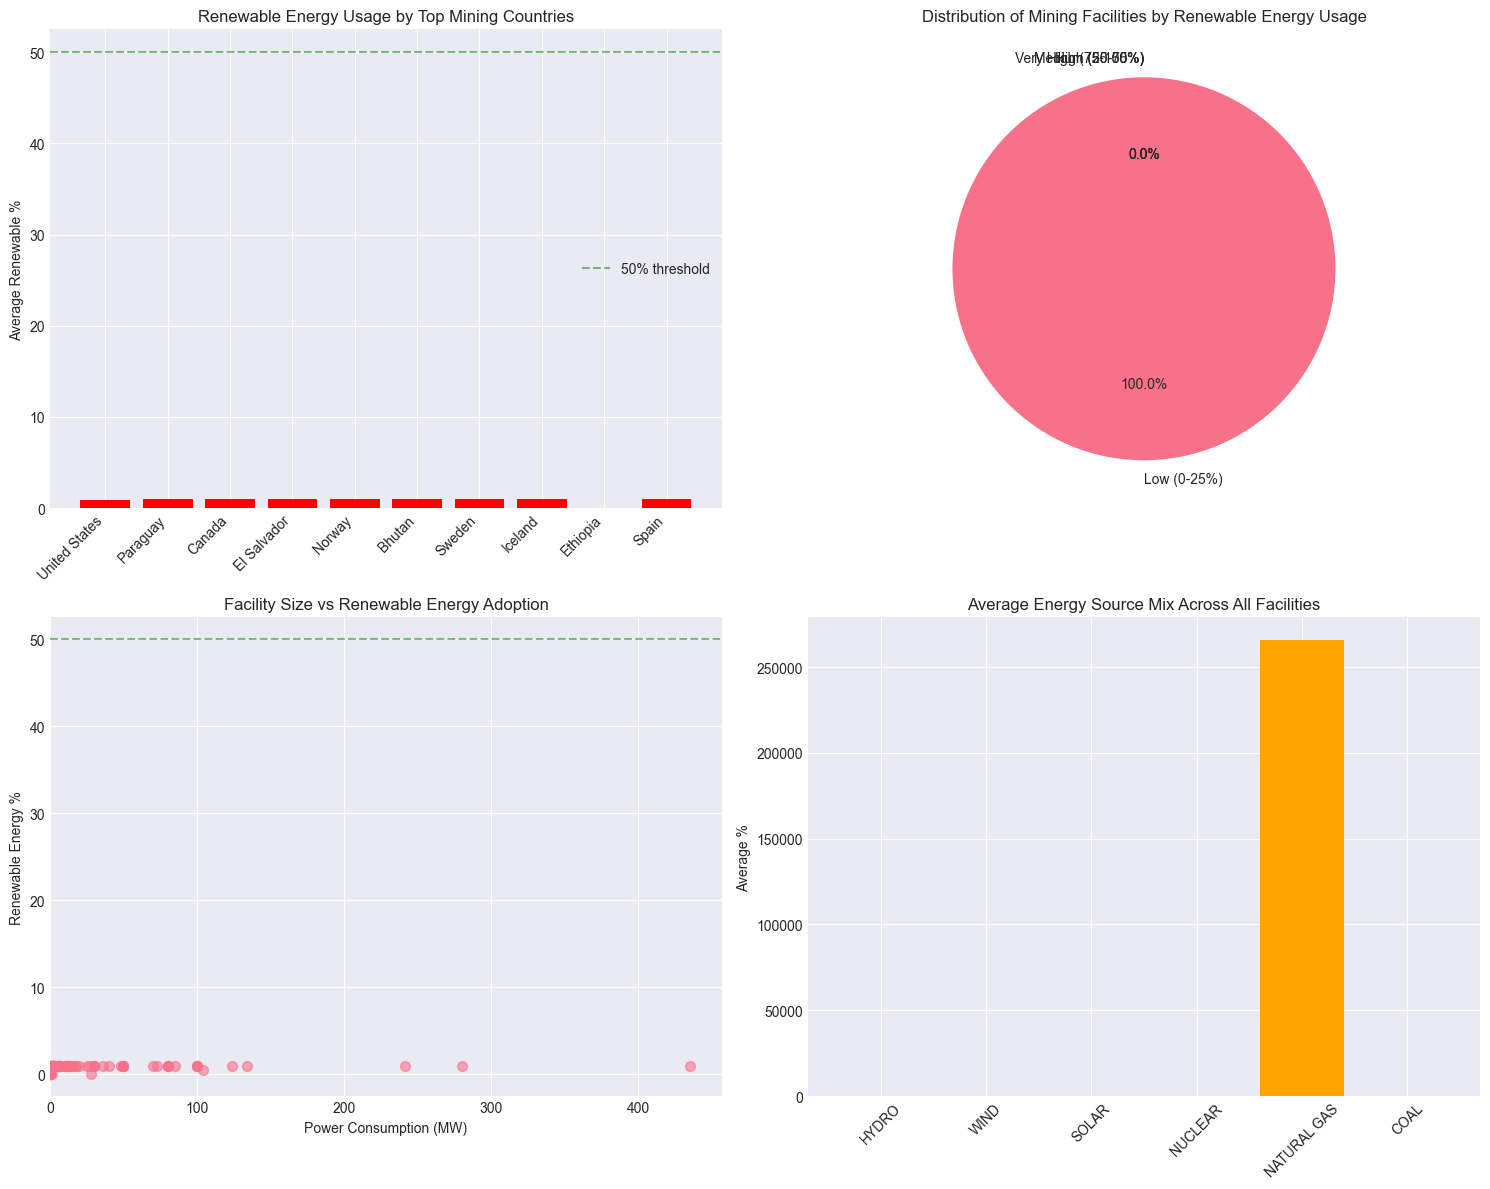

In [100]:
print("\n3.3 Renewable Energy Analysis")

# Robust cleaning for all relevant columns
def clean_percentage_column(col):
    """Convert percentage columns to numeric, handling various string formats"""
    # Convert to string first
    col = col.astype(str)
    
    # Replace common non-numeric values with 0
    replacements = {
        'Renewable': '0',
        'Wind': '0',
        'Solar': '0',
        'Hydro': '0',
        'Nuclear': '0',
        'Gas': '0',
        'Coal': '0',
        'N/A': '0',
        'NaN': '0'
    }
    for key, value in replacements.items():
        col = col.str.replace(key, value, case=False)
    
    # Remove percentage signs and other non-numeric characters
    col = col.str.replace('%', '')
    col = col.str.replace(r'[^\d\.]', '', regex=True)  # Remove non-digit/non-decimal characters
    
    # Convert to float and handle missing values
    return pd.to_numeric(col, errors='coerce').fillna(0)

# Clean all percentage columns
percent_cols = ['HYDRO%', 'WIND%', 'SOLAR%', 'NUCLEAR%', 'NATURAL GAS%', 'COAL%']
for col in percent_cols:
    renewable_mining[col] = clean_percentage_column(renewable_mining[col])

# Recalculate percentages
renewable_mining['total_renewable_percent'] = (
    renewable_mining['HYDRO%'] + 
    renewable_mining['WIND%'] + 
    renewable_mining['SOLAR%'] + 
    renewable_mining['NUCLEAR%']
)

renewable_mining['fossil_fuel_percent'] = (
    renewable_mining['NATURAL GAS%'] + 
    renewable_mining['COAL%']
)

# Clean power consumption column
if 'POWER CONSUMPTION (MW)' in renewable_mining:
    renewable_mining['POWER CONSUMPTION (MW)'] = (
        renewable_mining['POWER CONSUMPTION (MW)']
        .astype(str)
        .str.replace(',', '')
        .str.replace(r'[^\d\.]', '', regex=True)
        .replace('', '0')
        .astype(float)
        .fillna(0)
    )

# Now proceed with the analysis as before
country_renewables = renewable_mining.groupby('Country').agg({
    'POWER CONSUMPTION (MW)': 'sum',
    'total_renewable_percent': 'mean',
    'fossil_fuel_percent': 'mean',
    'Company': 'count'
}).reset_index()

country_renewables.columns = ['Country', 'Total_MW', 'Avg_Renewable_%', 'Avg_Fossil_%', 'Num_Facilities']
country_renewables = country_renewables.sort_values('Total_MW', ascending=False)

print("\nTop 10 Countries by Mining Capacity:")
print(country_renewables.head(10))

# Visualization 3: Renewable Energy Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Renewable % by top countries
top_countries_renewable = country_renewables.head(10)
colors = ['green' if x > 50 else 'orange' if x > 25 else 'red' 
          for x in top_countries_renewable['Avg_Renewable_%']]
ax1.bar(range(len(top_countries_renewable)), top_countries_renewable['Avg_Renewable_%'], color=colors)
ax1.set_xticks(range(len(top_countries_renewable)))
ax1.set_xticklabels(top_countries_renewable['Country'], rotation=45, ha='right')
ax1.axhline(y=50, color='green', linestyle='--', alpha=0.5, label='50% threshold')
ax1.set_ylabel('Average Renewable %')
ax1.set_title('Renewable Energy Usage by Top Mining Countries')
ax1.legend()

# 2. Distribution of facilities by renewable category
renewable_mining['renewable_category'] = pd.cut(
    renewable_mining['total_renewable_percent'],
    bins=[0, 25, 50, 75, 100],
    labels=['Low (0-25%)', 'Medium (25-50%)', 'High (50-75%)', 'Very High (75-100%)']
)
category_counts = renewable_mining['renewable_category'].value_counts()
ax2.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Mining Facilities by Renewable Energy Usage')

# 3. Scatter plot: Capacity vs Renewable %
ax3.scatter(renewable_mining['POWER CONSUMPTION (MW)'], 
           renewable_mining['total_renewable_percent'],
           alpha=0.6, s=50)
ax3.set_xlabel('Power Consumption (MW)')
ax3.set_ylabel('Renewable Energy %')
ax3.set_title('Facility Size vs Renewable Energy Adoption')
ax3.axhline(y=50, color='green', linestyle='--', alpha=0.5)
ax3.set_xlim(left=0)

# 4. Energy source breakdown
energy_sources = ['HYDRO%', 'WIND%', 'SOLAR%', 'NUCLEAR%', 'NATURAL GAS%', 'COAL%']
energy_means = [renewable_mining[source].mean() for source in energy_sources]

colors_energy = ['blue', 'cyan', 'yellow', 'green', 'orange', 'black']
ax4.bar(range(len(energy_sources)), energy_means, color=colors_energy)
ax4.set_xticks(range(len(energy_sources)))
ax4.set_xticklabels([s.replace('%', '') for s in energy_sources], rotation=45)
ax4.set_ylabel('Average %')
ax4.set_title('Average Energy Source Mix Across All Facilities')

plt.tight_layout()
plt.show()


3.4 Governance and Mining Relationship Analysis

Merged 9 countries with both mining and governance data

Correlations between governance indicators and mining hashrate:
Control of Corruption          +0.138
Government Effectiveness       +0.239
Political Stability            +0.019
Rule of Law                    +0.161
Regulatory Quality             +0.179
Voice and Accountability       -0.017


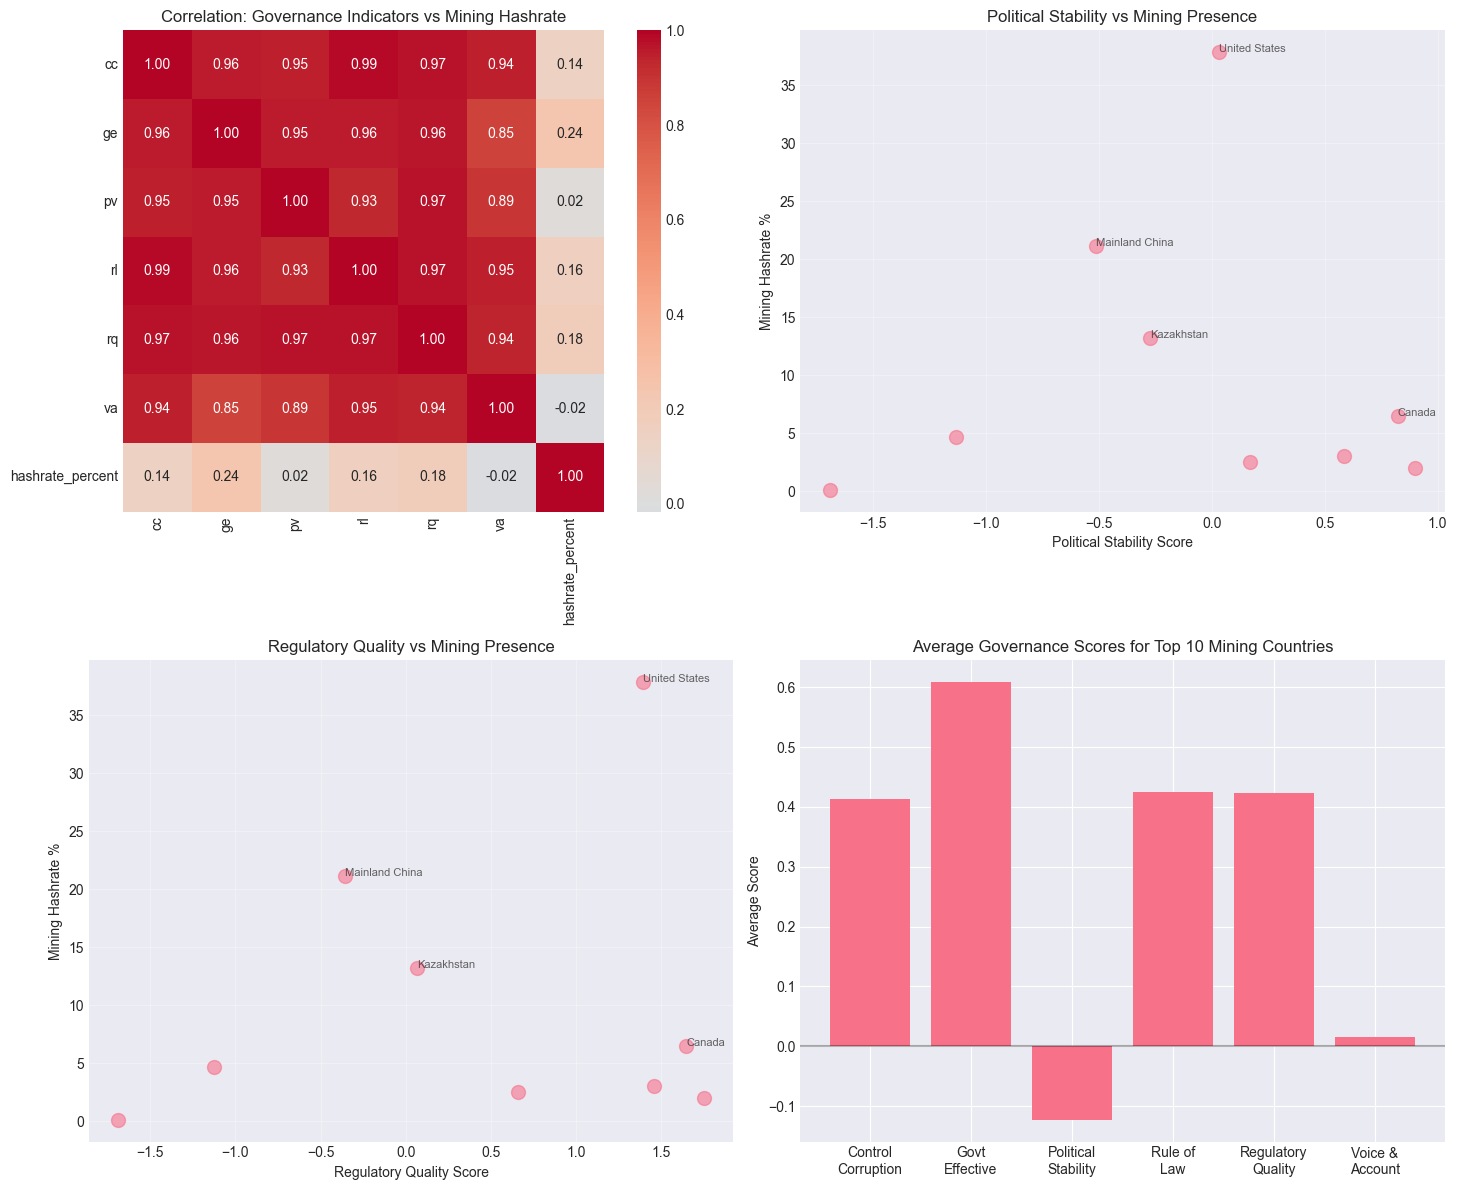

In [101]:
print("\n3.4 Governance and Mining Relationship Analysis")

# Merge mining data with governance indicators
# First, get latest mining distribution
latest_mining = country_share[country_share['date'] == latest_date][['country', 'hashrate_percent']].copy()

# Get latest WGI data (most recent year available)
latest_wgi_year = wgi_pivot['year'].max()
latest_wgi = wgi_pivot[wgi_pivot['year'] == latest_wgi_year].copy()

# Create country name mapping for merging
country_mapping = {
    'United States': 'United States',
    'Russian Federation': 'Russian Federation',
    'Mainland China': 'China',
    'Iran, Islamic Rep.': 'Iran, Islamic Rep.',
    'Germany *': 'Germany',
    'Ireland *': 'Ireland'
}

latest_mining['country_mapped'] = latest_mining['country'].map(
    lambda x: country_mapping.get(x, x)
)

# Merge datasets
governance_mining = pd.merge(
    latest_mining,
    latest_wgi,
    left_on='country_mapped',
    right_on='countryname',
    how='inner'
)

print(f"\nMerged {len(governance_mining)} countries with both mining and governance data")

# Calculate correlations
governance_indicators = ['cc', 'ge', 'pv', 'rl', 'rq', 'va']
correlations = {}
for indicator in governance_indicators:
    if indicator in governance_mining.columns:
        corr = governance_mining['hashrate_percent'].corr(governance_mining[indicator])
        correlations[indicator] = corr

print("\nCorrelations between governance indicators and mining hashrate:")
for ind, corr in correlations.items():
    indicator_names = {
        'cc': 'Control of Corruption',
        'ge': 'Government Effectiveness',
        'pv': 'Political Stability',
        'rl': 'Rule of Law',
        'rq': 'Regulatory Quality',
        'va': 'Voice and Accountability'
    }
    print(f"{indicator_names.get(ind, ind):30} {corr:+.3f}")

# Visualization 4: Governance Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Correlation heatmap
if len(governance_mining) > 5:  # Need sufficient data for meaningful correlation
    corr_matrix = governance_mining[governance_indicators + ['hashrate_percent']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax1, 
                fmt='.2f', square=True)
    ax1.set_title('Correlation: Governance Indicators vs Mining Hashrate')

# 2. Political Stability vs Mining
if 'pv' in governance_mining.columns:
    ax2.scatter(governance_mining['pv'], governance_mining['hashrate_percent'], s=100, alpha=0.6)
    for idx, row in governance_mining.iterrows():
        if row['hashrate_percent'] > 5:  # Label major mining countries
            ax2.annotate(row['country'], (row['pv'], row['hashrate_percent']), 
                        fontsize=8, alpha=0.7)
    ax2.set_xlabel('Political Stability Score')
    ax2.set_ylabel('Mining Hashrate %')
    ax2.set_title('Political Stability vs Mining Presence')
    ax2.grid(True, alpha=0.3)

# 3. Regulatory Quality vs Mining
if 'rq' in governance_mining.columns:
    ax3.scatter(governance_mining['rq'], governance_mining['hashrate_percent'], s=100, alpha=0.6)
    for idx, row in governance_mining.iterrows():
        if row['hashrate_percent'] > 5:
            ax3.annotate(row['country'], (row['rq'], row['hashrate_percent']), 
                        fontsize=8, alpha=0.7)
    ax3.set_xlabel('Regulatory Quality Score')
    ax3.set_ylabel('Mining Hashrate %')
    ax3.set_title('Regulatory Quality vs Mining Presence')
    ax3.grid(True, alpha=0.3)

# 4. Top mining countries governance profile
top_mining_gov = governance_mining.nlargest(10, 'hashrate_percent')
if len(top_mining_gov) > 0:
    gov_scores = top_mining_gov[governance_indicators].mean()
    ax4.bar(range(len(governance_indicators)), gov_scores.values)
    ax4.set_xticks(range(len(governance_indicators)))
    ax4.set_xticklabels(['Control\nCorruption', 'Govt\nEffective', 'Political\nStability', 
                         'Rule of\nLaw', 'Regulatory\nQuality', 'Voice &\nAccount'])
    ax4.set_ylabel('Average Score')
    ax4.set_title('Average Governance Scores for Top 10 Mining Countries')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [102]:
print("\n3.5 Facility-Level Analysis")

# US State analysis (if State column exists)
if 'State' in renewable_mining.columns:
    us_facilities = renewable_mining[renewable_mining['Country'] == 'United States'].copy()
    if len(us_facilities) > 0:
        us_state_summary = us_facilities.groupby('State').agg({
            'POWER CONSUMPTION (MW)': 'sum',
            'total_renewable_percent': 'mean',
            'Company': 'count'
        }).reset_index()
        us_state_summary.columns = ['State', 'Total_MW', 'Avg_Renewable_%', 'Num_Facilities']
        us_state_summary = us_state_summary.sort_values('Total_MW', ascending=False)
        
        print("\nUS Mining by State:")
        print(us_state_summary.head(10))

# Global facility size distribution
print("\nFacility Size Distribution:")
print(renewable_mining['POWER CONSUMPTION (MW)'].describe())

# Largest facilities
print("\nTop 10 Largest Mining Facilities:")
largest_facilities = renewable_mining.nlargest(10, 'POWER CONSUMPTION (MW)')[
    ['Company', 'Country', 'POWER CONSUMPTION (MW)', 'total_renewable_percent', 'TYPE OF ENERGY']
]
print(largest_facilities)


3.5 Facility-Level Analysis

US Mining by State:
          State  Total_MW  Avg_Renewable_%  Num_Facilities
2      New York     630.0         0.699200               5
4         Texas     370.0         1.000000               3
3  Pennsylvania     215.0         0.960000               3
5    Washington      28.0         0.993333               3
1       Georgia      20.0         1.000000               1
0      Colorado       6.0         1.000000               1
6     Wisconsin       1.4         1.000000               1

Facility Size Distribution:
count     95.000000
mean      30.620000
std       62.805095
min        0.000000
25%        2.000000
50%        6.000000
75%       30.000000
max      435.000000
Name: POWER CONSUMPTION (MW), dtype: float64

Top 10 Largest Mining Facilities:
                               Company        Country  POWER CONSUMPTION (MW)  \
1                         Coinmint Llc  United States                   435.0   
28                         Hut 8 Corp.  United 

In [103]:
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

print("\n1. Mining Distribution Summary:")
print(f"   - Number of countries with mining: {latest_distribution['country'].nunique()}")
print(f"   - Total global hashrate: {latest_distribution['monthly_absolute_hashrate_EH/S'].sum():.1f} EH/s")
print(f"   - Top 5 countries control: {latest_distribution.head(5)['hashrate_percent'].sum():.1f}% of hashrate")

print("\n2. Renewable Energy Summary:")
print(f"   - Total facilities analyzed: {len(renewable_mining)}")
print(f"   - Average renewable energy %: {renewable_mining['total_renewable_percent'].mean():.1f}%")
print(f"   - Facilities with >50% renewable: {(renewable_mining['total_renewable_percent'] > 50).sum()} ({(renewable_mining['total_renewable_percent'] > 50).mean()*100:.1f}%)")
print(f"   - Total power consumption: {renewable_mining['POWER CONSUMPTION (MW)'].sum():.0f} MW")

print("\n3. Geographic Distribution:")
print(f"   - Countries with mining facilities: {renewable_mining['Country'].nunique()}")
print(f"   - Average facilities per country: {len(renewable_mining) / renewable_mining['Country'].nunique():.1f}")

# Save processed data for next phase
print("\n" + "=" * 80)
print("SAVING PROCESSED DATA FOR NEXT PHASE")
print("=" * 80)

# Create integrated dataset for modeling
integrated_data = {
    'country_share': country_share,
    'renewable_mining': renewable_mining,
    'wgi_pivot': wgi_pivot,
    'iea_electricity': iea_electricity,
    'latest_distribution': latest_distribution,
    'country_renewables': country_renewables,
    'governance_mining': governance_mining
}

# Save to pickle for easy loading in next phase
import pickle
with open('integrated_mining_data.pkl', 'wb') as f:
    pickle.dump(integrated_data, f)

print("\nData saved to 'integrated_mining_data.pkl' for feature engineering and modeling phase")
print("\nEDA Complete! Key insights:")
print("1. Mining has significantly redistributed post-China ban")
print("2. US, Kazakhstan, and Russia emerged as major players")
print("3. Renewable energy adoption varies significantly by country")
print("4. Governance factors show mixed correlation with mining presence")
print("5. Facility sizes range from small (<10MW) to massive (>400MW) operations")


SUMMARY STATISTICS

1. Mining Distribution Summary:
   - Number of countries with mining: 10
   - Total global hashrate: 187.5 EH/s
   - Top 5 countries control: 87.7% of hashrate

2. Renewable Energy Summary:
   - Total facilities analyzed: 95
   - Average renewable energy %: 0.9%
   - Facilities with >50% renewable: 0 (0.0%)
   - Total power consumption: 2909 MW

3. Geographic Distribution:
   - Countries with mining facilities: 10
   - Average facilities per country: 9.5

SAVING PROCESSED DATA FOR NEXT PHASE

Data saved to 'integrated_mining_data.pkl' for feature engineering and modeling phase

EDA Complete! Key insights:
1. Mining has significantly redistributed post-China ban
2. US, Kazakhstan, and Russia emerged as major players
3. Renewable energy adoption varies significantly by country
4. Governance factors show mixed correlation with mining presence
5. Facility sizes range from small (<10MW) to massive (>400MW) operations
